# Tools and data preparation

In [7]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2d9393d6b25e267103b0873fd7f665c0f011b9b530d28faecf2359fa435cbb98
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
import shap
from lime import lime_tabular
from matplotlib.lines import Line2D


In [10]:
# Mengatur tampilan output pandas agar lebih rapi
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
bank = pd.read_csv('/content/drive/MyDrive/Purwadhika/bank.csv')

In [ ]:
# Harapan output analisa Bisnis ---
# Membangun model untuk memprediksi apakah klien akan berlangganan deposito berjangka ('yes'/'no').
# Kriteria keberhasilan: Akurasi min 85%, Recall tinggi untuk kelas 'yes'.

# Data Understanding

In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [ ]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [13]:
cek_contact = bank['contact'].value_counts()
print(cek_contact)


contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64


In [ ]:
# Hitung jumlah orang yang memiliki pinjaman (housing 'yes' ATAU loan 'yes')
has_any_loan = bank[(bank['housing'] == 'yes') | (bank['loan'] == 'yes')].shape[0]

# Hitung jumlah orang yang tidak memiliki pinjaman (housing 'no' DAN loan 'no')
has_no_loan = bank[(bank['housing'] == 'no') & (bank['loan'] == 'no')].shape[0]

print("Data peminjaman")
print(f'{has_any_loan} orang memiliki setidaknya punya satu jenis pinjaman ')
print(f'{has_no_loan} orang tidak memiliki pinjaman sama sekali')

Data peminjaman
5906 orang memiliki setidaknya punya satu jenis pinjaman 
5256 orang tidak memiliki pinjaman sama sekali


In [ ]:
count_job = bank['job'].value_counts()
count_martial = bank['marital'].value_counts()
count_default = bank['default'].value_counts()
count_housing = bank['housing'].value_counts()
count_loan = bank['loan'].value_counts()

print(f"{count_job}\n")
print(f"{count_martial}\n")
print(f"{count_default}\n")
print(f"{count_housing}\n")
print(f"{count_loan}\n")



job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64

default
no     10994
yes      168
Name: count, dtype: int64

housing
no     5881
yes    5281
Name: count, dtype: int64

loan
no     9702
yes    1460
Name: count, dtype: int64



In [ ]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [ ]:
print("\nDistribusi kelas target 'deposit':")
print(bank['deposit'].value_counts())
print(f"Proporsi kelas 'yes': {bank['deposit'].value_counts(normalize=True)['yes']:.2f}")
print(f"Proporsi kelas 'no': {bank['deposit'].value_counts(normalize=True)['no']:.2f}")
# Catatan: Dataset terlihat sedikit tidak seimbang, 'no' lebih dominan. Ini perlu diperhatikan dalam evaluasi.


Distribusi kelas target 'deposit':
deposit
no     5873
yes    5289
Name: count, dtype: int64
Proporsi kelas 'yes': 0.47
Proporsi kelas 'no': 0.53


In [ ]:
# Proporsi data masih cukup balance antara 47:53

In [ ]:
print("Cek nilai 'unknown' pada fitur kategorikal dan -1 pada 'pdays':")
for column in bank.select_dtypes(include='object').columns:
    if 'unknown' in bank[column].unique():
        print(f"Kolom '{column}' memiliki {bank[column].value_counts().get('unknown', 0)} nilai 'unknown'.")
if -1 in bank['pdays'].unique():
    print(f"Kolom 'pdays' memiliki {bank['pdays'].value_counts().get(-1, 0)} nilai -1.")

Cek nilai 'unknown' pada fitur kategorikal dan -1 pada 'pdays':
Kolom 'job' memiliki 70 nilai 'unknown'.
Kolom 'education' memiliki 497 nilai 'unknown'.
Kolom 'contact' memiliki 2346 nilai 'unknown'.
Kolom 'poutcome' memiliki 8326 nilai 'unknown'.
Kolom 'pdays' memiliki 8324 nilai -1.


# Preparation data

In [ ]:
# Buat salinan dataset bank
bank_processed = bank.copy()

In [ ]:
# Cleaning data dengan tujuan:
# Menangani nilai 'unknown'.
# Nilai 'unknown' pada fitur kategorikal akan diperlakukan sebagai kategori terpisah.

# Menangani -1 pada 'pdays'
# -1 pada 'pdays' berarti klien tidak pernah dihubungi sebelumnya.

In [ ]:
bank_processed['pdays_contacted'] = bank_processed['pdays'].apply(lambda x: 0 if x == -1 else 1)
bank_processed['pdays'] = bank_processed['pdays'].replace(-1, 0) # Mengubah -1 menjadi 0 setelah fitur biner dibuat

In [ ]:
# Cek duplikat, jika ada dihapus
initial_rows = bank_processed.shape[0]
bank_processed.drop_duplicates(inplace=True)
rows_after_duplicates = bank_processed.shape[0]
if initial_rows - rows_after_duplicates > 0:
    print(f"Ditemukan dan dihapus {initial_rows - rows_after_duplicates} baris duplikat.")
else:
    print("Tidak ditemukan duplikat.")

Tidak ditemukan duplikat.


In [ ]:
# Menangani Outlier:
# Untuk demonstrasi, gunakan visualisasi boxplot dan capping (membatasi nilai ekstrem)
# untuk beberapa fitur numerik yang diketahui memiliki outlier parah seperti 'balance' dan 'duration'. akan menggunakan IQR method for capping

print("\n--- Menangani Outlier (Capping dengan IQR) ---")
numerical_cols_for_outlier = ['balance', 'duration', 'campaign', 'previous']
for col in numerical_cols_for_outlier:
    Q1 = bank_processed[col].quantile(0.25)
    Q3 = bank_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    bank_processed[col] = np.where(bank_processed[col] < lower_bound, lower_bound, bank_processed[col])
    bank_processed[col] = np.where(bank_processed[col] > upper_bound, upper_bound, bank_processed[col])
    print(f"Outlier pada '{col}' telah di-capping.")


--- Menangani Outlier (Capping dengan IQR) ---
Outlier pada 'balance' telah di-capping.
Outlier pada 'duration' telah di-capping.
Outlier pada 'campaign' telah di-capping.
Outlier pada 'previous' telah di-capping.


In [ ]:
print("Feature Engineering:")

# Fitur 'duration' adalah fitur yang diketahui hanya setelah panggilan selesai.
# Menggunakannya untuk memprediksi apakah seseorang akan berlangganan deposito adalah akan menyebabkan data leakage
# Action didrop

print("PENTING: Kolom 'duration' akan dihapus karena menyebabkan data leakage (informasi ini tidak akan tersedia saat prediksi).")
bank_processed.drop('duration', axis=1, inplace=True)

# Sudah diklik drop sebelumnya jadi muncul error

Feature Engineering:
PENTING: Kolom 'duration' akan dihapus karena menyebabkan data leakage (informasi ini tidak akan tersedia saat prediksi).


In [ ]:
# Fitur Berbasis Waktu dari 'month'
# Fitur ini bisa membuat fitur 'month_num' untuk memudahkan ekstraksi atau melihat pola musiman
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
bank_processed['month_num'] = bank_processed['month'].map(month_map)
print("Fitur 'month_num' (numerik dari bulan) dibuat.")

Fitur 'month_num' (numerik dari bulan) dibuat.


In [ ]:
# Fitur Agregasi (contoh: rasio 'previous' (jumlah kontak sebelumnya) dengan 'pdays' (hari sejak kontak terakhir) jika pdays tidak 0)
# Ini bisa mengindikasikan seberapa sering mereka dihubungi dalam periode tertentu.
bank_processed['previous_per_pdays'] = bank_processed.apply(lambda row: row['previous'] / row['pdays'] if row['pdays'] > 0 else 0, axis=1)
print("Fitur 'previous_per_pdays' dibuat.")

Fitur 'previous_per_pdays' dibuat.


In [ ]:
# Fitur 'age_group'
bank_processed['age_group'] = pd.cut(bank_processed['age'], bins=[0, 25, 35, 45, 55, 65, np.inf],
                                   labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])
print("Fitur 'age_group' dibuat.")

Fitur 'age_group' dibuat.


In [ ]:
# drop kolom 'month' yang asli karena sudah diwakili oleh 'month_num'
bank_processed.drop('month', axis=1, inplace=True)

In [ ]:
# Tampilkan hasil update Feature Engineering

bank_processed.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,campaign,pdays,previous,poutcome,deposit,pdays_contacted,month_num,previous_per_pdays,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,1.0,0,0.0,unknown,yes,0,5,0.0,55-65
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,1.0,0,0.0,unknown,yes,0,5,0.0,55-65
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,1.0,0,0.0,unknown,yes,0,5,0.0,35-45
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,1.0,0,0.0,unknown,yes,0,5,0.0,45-55
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,2.0,0,0.0,unknown,yes,0,5,0.0,45-55


# Splitting data training dan data test

In [ ]:
# Pembagian Data (Training, Validation, Test)")
X = bank_processed.drop('deposit', axis=1)
y = bank_processed['deposit']

# Encoding variabel target 'deposit' (yes=1, no=0)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Mapping target: {list(le.classes_)} -> {list(le.transform(le.classes_))}")

# Bagi data menjadi training (80%) dan temporary (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Bagi temporary menjadi validation (10%) dan test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Ukuran data pelatihan: {X_train.shape[0]} baris")
print(f"Ukuran data validasi: {X_val.shape[0]} baris")
print(f"Ukuran data pengujian: {X_test.shape[0]} baris")


Mapping target: ['no', 'yes'] -> [np.int64(0), np.int64(1)]
Ukuran data pelatihan: 8929 baris
Ukuran data validasi: 1116 baris
Ukuran data pengujian: 1117 baris


In [ ]:
# Identifikasi kolom numerik dan kategorikal untuk preprocessing
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

if 'age' in numerical_cols: # age_group dibuat dari age, jadi age mungkin ingin diskalakan
    pass # Tetap biarkan age di numerical_cols
# 'age_group' sudah otomatis masuk ke categorical_cols karena perbaikan di atas.

print("\nKolom Numerik untuk Scaling:", numerical_cols)
print("Kolom Kategorikal untuk One-Hot Encoding:", categorical_cols)


Kolom Numerik untuk Scaling: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'pdays_contacted', 'month_num', 'previous_per_pdays']
Kolom Kategorikal untuk One-Hot Encoding: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'age_group']


In [ ]:
# Cek 'pdays_contacted' dan 'previous_per_pdays' ada di `numerical_cols`
if 'pdays_contacted' not in numerical_cols:
    numerical_cols.append('pdays_contacted')
if 'previous_per_pdays' not in numerical_cols:
    numerical_cols.append('previous_per_pdays')
if 'month_num' not in numerical_cols:
    numerical_cols.append('month_num')

# Kolom 'deposit' tidak ada di data X, jadi tidak perlu di-handle di sini.
# Kolom 'duration' sudah dihapus.
# Kolom 'month' sudah dihapus.

In [ ]:
# Buat preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Skala numerik
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) # One-hot encode kategorikal
    ],
    remainder='passthrough' # Biarkan kolom lain yang tidak masuk ke transformer (jika ada)
)

# Modelling

In [ ]:
# Definisikan model-model yang akan dicoba
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'), # liblinear lebih baik untuk dataset kecil
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42), # probability=True untuk ROC AUC
    'Naive Bayes': GaussianNB()
}

# Pipeline untuk setiap model
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', model)])


In [ ]:
# Melatih model dan evaluasi awal dengan cross-validation
print("\nMelatih dan mengevaluasi model dengan Cross-Validation (5-Fold)...")
results = {}
for name, pipeline in pipelines.items():
    print(f"\nMelatih {name}...")
    # Menggunakan StratifiedKFold untuk menjaga proporsi kelas di setiap fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1) # Fokus pada recall
    accuracy_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    results[name] = {'Recall (CV)': np.mean(scores), 'Accuracy (CV)': np.mean(accuracy_scores)}
    print(f"{name} - Recall (Cross-Validation): {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    print(f"{name} - Accuracy (Cross-Validation): {np.mean(accuracy_scores):.4f} (+/- {np.std(accuracy_scores):.4f})")


Melatih dan mengevaluasi model dengan Cross-Validation (5-Fold)...

Melatih Logistic Regression...
Logistic Regression - Recall (Cross-Validation): 0.6065 (+/- 0.0212)
Logistic Regression - Accuracy (Cross-Validation): 0.6967 (+/- 0.0081)

Melatih Decision Tree...
Decision Tree - Recall (Cross-Validation): 0.6129 (+/- 0.0183)
Decision Tree - Accuracy (Cross-Validation): 0.6340 (+/- 0.0092)

Melatih Random Forest...
Random Forest - Recall (Cross-Validation): 0.6320 (+/- 0.0131)
Random Forest - Accuracy (Cross-Validation): 0.7122 (+/- 0.0035)

Melatih Gradient Boosting...
Gradient Boosting - Recall (Cross-Validation): 0.6277 (+/- 0.0144)
Gradient Boosting - Accuracy (Cross-Validation): 0.7348 (+/- 0.0078)

Melatih Support Vector Machine...
Support Vector Machine - Recall (Cross-Validation): 0.5887 (+/- 0.0209)
Support Vector Machine - Accuracy (Cross-Validation): 0.7053 (+/- 0.0088)

Melatih Naive Bayes...
Naive Bayes - Recall (Cross-Validation): 0.4952 (+/- 0.0154)
Naive Bayes - Accura

In [ ]:
# Menentukan model terbaik berdasarkan recall (sesuai kriteria keberhasilan)
best_model_name = max(results, key=lambda k: results[k]['Recall (CV)'])
print(f"\nModel terbaik berdasarkan Recall Cross-Validation di Training Set: {best_model_name}")

# Penyetelan Hyperparameter untuk model terbaik
print(f"\nPenyetelan Hyperparameter untuk {best_model_name} (menggunakan GridSearchCV)")




Model terbaik berdasarkan Recall Cross-Validation di Training Set: Random Forest

Penyetelan Hyperparameter untuk Random Forest (menggunakan GridSearchCV)


In [ ]:
pipelines[best_model_name]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'campaign', 'pdays',
                                                   'previous',
                                                   'pdays_contacted',
                                                   'month_num',
                                                   'previous_per_pdays']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome',
                                                   'age_group'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
# Definisikan parameter grid untuk model terbaik
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'Support Vector Machine': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf', 'linear']
    },
    'Naive Bayes': {} # GaussianNB biasanya tidak banyak hyperparameter untuk tuning
}

# Lakukan GridSearchCV pada model terbaik
grid_search = GridSearchCV(pipelines[best_model_name], param_grids[best_model_name],
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='recall', n_jobs=-1, verbose=1)


In [ ]:
grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'pdays_contacted',
                                                                          'month_num',
                                                                          'previous_per_pdays']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'poutcome',
                                                                          'age_group'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='recall', verbose=1)

In [ ]:
# Evaluasi model awal (sebelum tuning)
initial_model = pipelines[best_model_name]  # Model awal tanpa tuning

# Menghitung skor recall sebelum tuning
initial_score = cross_val_score(initial_model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='recall', n_jobs=-1)
initial_mean_score = initial_score.mean()

print(f"Recall score before hyperparameter tuning: {initial_mean_score:.4f}")

Recall score before hyperparameter tuning: 0.6320


In [ ]:
# gunakan X_train saja jika cross-validation
# Untuk tujuan demonstrasi dan mengikuti alur, kita akan GridSearchCV pada X_train.
print("Melakukan Grid Search pada data pelatihan (X_train)...")
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_
print(f"\nHasil Grid Search untuk {best_model_name}:")
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best Recall score on training data (with CV): {grid_search.best_score_:.4f}")

Melakukan Grid Search pada data pelatihan (X_train)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Hasil Grid Search untuk Random Forest:
Best Hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Recall score on training data (with CV): 0.6334


In [ ]:
# Evaluasi model terbaik pada data validasi (X_val, y_val)
print(f"\n--- Evaluasi Model Terbaik ({best_model_name}) pada Data Validasi ---")
y_val_pred = best_pipeline.predict(X_val)
y_val_proba = best_pipeline.predict_proba(X_val)[:, 1]

print("\nConfusion Matrix (Validation Set):")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


--- Evaluasi Model Terbaik (Random Forest) pada Data Validasi ---

Confusion Matrix (Validation Set):
[[466 121]
 [204 325]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

          no       0.70      0.79      0.74       587
         yes       0.73      0.61      0.67       529

    accuracy                           0.71      1116
   macro avg       0.71      0.70      0.70      1116
weighted avg       0.71      0.71      0.71      1116



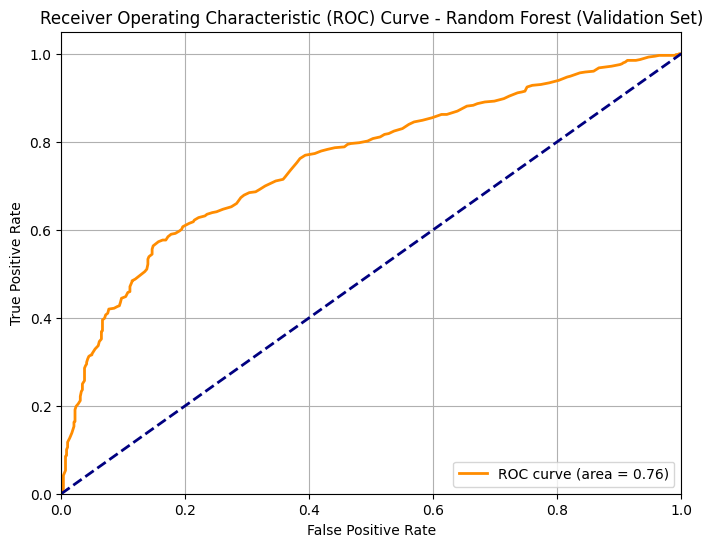

In [ ]:
# Visualisasi ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve - {best_model_name} (Validation Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
print(f"Accuracy on Validation Set: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision on Validation Set: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall on Validation Set: {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-Score on Validation Set: {f1_score(y_val, y_val_pred):.4f}")
print(f"AUC on Validation Set: {roc_auc_val:.4f}")

Accuracy on Validation Set: 0.7088
Precision on Validation Set: 0.7287
Recall on Validation Set: 0.6144
F1-Score on Validation Set: 0.6667
AUC on Validation Set: 0.7557


# Evaluation Model


Evaluasi Model Akhir (Random Forest) pada Data Pengujian (Test Set)


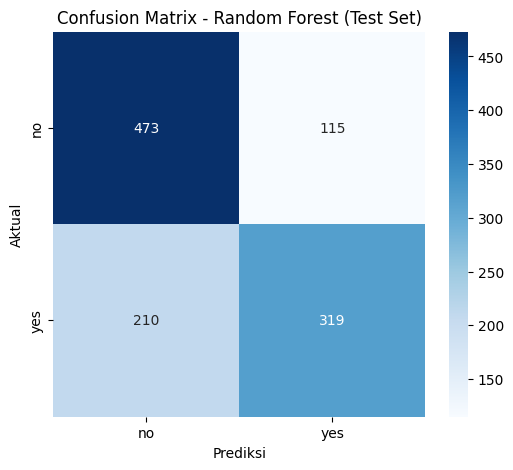

In [ ]:
# Evaluasi akhir pada data pengujian (Test Set)
print(f"\nEvaluasi Model Akhir ({best_model_name}) pada Data Pengujian (Test Set)")
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

#Confusion Matrix (Test Set)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.show()

In [ ]:
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

print(f"Accuracy on Test Set: {accuracy_test:.4f}")
print(f"Precision on Test Set: {precision_test:.4f}")
print(f"Recall on Test Set: {recall_test:.4f}")
print(f"F1-Score on Test Set: {f1_test:.4f}")
print(f"AUC on Test Set: {roc_auc_test:.4f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

          no       0.69      0.80      0.74       588
         yes       0.74      0.60      0.66       529

    accuracy                           0.71      1117
   macro avg       0.71      0.70      0.70      1117
weighted avg       0.71      0.71      0.71      1117

Accuracy on Test Set: 0.7090
Precision on Test Set: 0.7350
Recall on Test Set: 0.6030
F1-Score on Test Set: 0.6625
AUC on Test Set: 0.7715


In [ ]:
# Kembali ke goal apakah bisa mencapai 85% dan berapa recall nya?

# Cek kriteria keberhasilan
if accuracy_test >= 0.85:
    print(f"\nKriteria Keberhasilan (Akurasi): Tercapai! Akurasi model adalah {accuracy_test:.2%}.")
else:
    print(f"\nKriteria Keberhasilan (Akurasi): Tidak Tercapai. Akurasi model adalah {accuracy_test:.2%}. Target >= 85%.")

print(f"Fokus pada Recall untuk kelas 'yes': {recall_test:.4f}")
print("Meningkatkan recall mungkin memerlukan penyesuaian threshold klasifikasi atau strategi penanganan imbalance class (jika signifikan).")



Kriteria Keberhasilan (Akurasi): Tidak Tercapai. Akurasi model adalah 70.90%. Target >= 85%.
Fokus pada Recall untuk kelas 'yes': 0.6030
Meningkatkan recall mungkin memerlukan penyesuaian threshold klasifikasi atau strategi penanganan imbalance class (jika signifikan).


In [ ]:
print("\n--- Mendeteksi Overfitting/Underfitting ---")
print(f"Recall Training (Best CV): {grid_search.best_score_:.4f}")
print(f"Recall Validation: {recall_score(y_val, y_val_pred):.4f}")
print(f"Recall Test: {recall_test:.4f}")

if grid_search.best_score_ > recall_test + 0.05: # Ambang batas 5% sebagai indikasi
    print("Potensi Overfitting: Kinerja pelatihan jauh lebih baik daripada kinerja pengujian.")
elif grid_search.best_score_ < 0.60 and recall_test < 0.60: # Ambang batas rendah sebagai indikasi underfitting
    print("Potensi Underfitting: Kinerja model buruk pada pelatihan maupun pengujian.")
else:
    print("Model tampaknya memiliki keseimbangan yang baik antara bias dan varians (tidak ada overfitting/underfitting yang parah).")


--- Mendeteksi Overfitting/Underfitting ---
Recall Training (Best CV): 0.6334
Recall Validation: 0.6144
Recall Test: 0.6030
Model tampaknya memiliki keseimbangan yang baik antara bias dan varians (tidak ada overfitting/underfitting yang parah).



SHAP Summary Plot (Global Feature Importance):


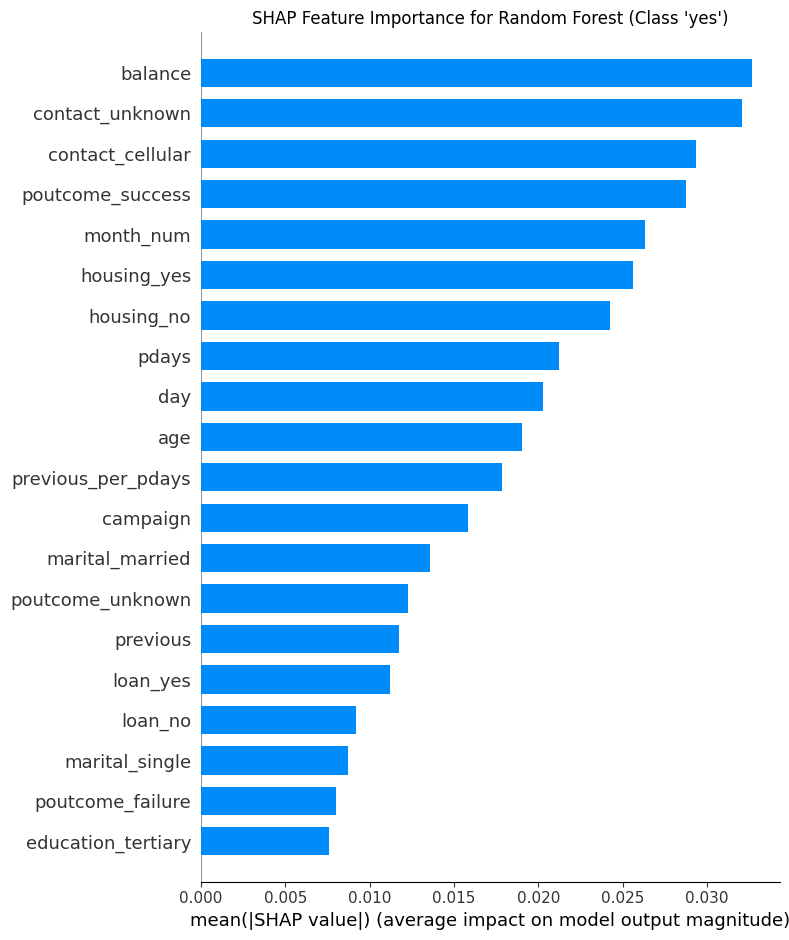


SHAP Dependency Plots (dengan legend):


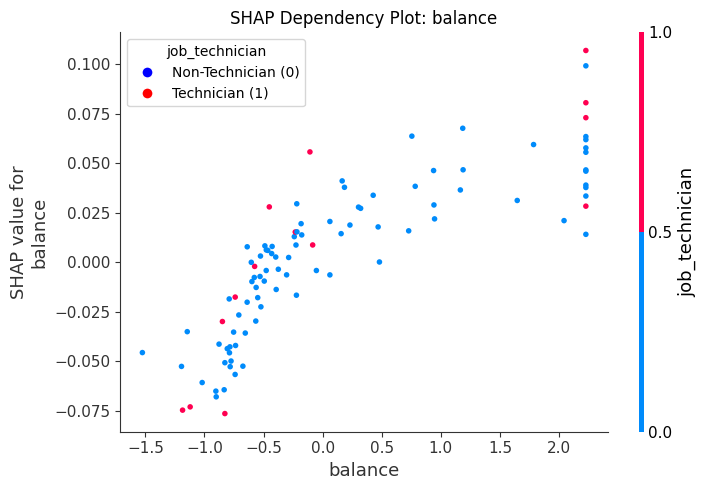

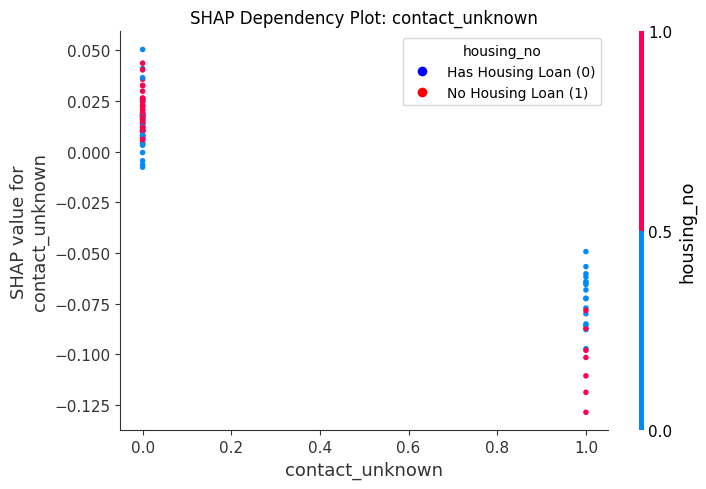

In [ ]:
# SHAP
try:
    # Dapatkan nama fitur setelah preprocessing
    ohe_feature_names = list(best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols))
    feature_names = numerical_cols + ohe_feature_names

    # Transformasi data latih
    X_train_processed = preprocessor.transform(X_train)
    if hasattr(X_train_processed, 'toarray'):
        X_train_processed = X_train_processed.toarray()

    X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

    # Pilih explainer sesuai jenis model
    model = best_pipeline.named_steps['classifier']
    if isinstance(model, (RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier)):
        explainer = shap.TreeExplainer(model)
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(model, X_train_processed_df)
    elif isinstance(model, SVC):
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train_processed_df, 100))
    else:
        explainer = shap.Explainer(model.predict_proba, X_train_processed_df)

    # Transformasi data uji
    X_test_processed = preprocessor.transform(X_test)
    if hasattr(X_test_processed, 'toarray'):
        X_test_processed = X_test_processed.toarray()

    X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

    # Sampel sebagian data uji
    sample_X_test_processed = shap.sample(X_test_processed_df, 100, random_state=42)
    shap_values = explainer.shap_values(sample_X_test_processed)

    # Tangani output shap_values tergantung model
    if isinstance(shap_values, list):
        shap_values_to_plot = shap_values[1]
    elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
        shap_values_to_plot = shap_values[:, :, 1]
    elif hasattr(shap_values, 'values'):
        shap_values_to_plot = shap_values.values
    else:
        shap_values_to_plot = shap_values

    # SHAP summary plot
    print("\nSHAP Summary Plot (Global Feature Importance):")
    shap.summary_plot(shap_values_to_plot, sample_X_test_processed, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance for {best_model_name} (Class 'yes')")
    plt.tight_layout()
    plt.show()

    # Ubah sample_X_test_processed ke NumPy array
    X_plot = sample_X_test_processed.values if isinstance(sample_X_test_processed, pd.DataFrame) else sample_X_test_processed

    print("\nSHAP Dependency Plots (dengan legend):")

    # Fitur dan interaksi (warna) untuk dua fitur teratas
    fitur_utama_1 = 'balance'
    fitur_warna_1 = 'job_technician'

    fitur_utama_2 = 'contact_unknown'
    fitur_warna_2 = 'housing_no'

    # Plot 1
    shap.dependence_plot(
        fitur_utama_1,
        shap_values_to_plot,
        sample_X_test_processed,
        interaction_index=fitur_warna_1,
        feature_names=feature_names,
        show=False
    )
    legend_elements_1 = [
        Line2D([0], [0], marker='o', color='w', label='Non-Technician (0)', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Technician (1)', markerfacecolor='red', markersize=8)
    ]
    plt.legend(handles=legend_elements_1, title=fitur_warna_1)
    plt.title(f"SHAP Dependency Plot: {fitur_utama_1}")
    plt.tight_layout()
    plt.show()

    # Plot 2
    shap.dependence_plot(
        fitur_utama_2,
        shap_values_to_plot,
        sample_X_test_processed,
        interaction_index=fitur_warna_2,
        feature_names=feature_names,
        show=False
    )
    legend_elements_2 = [
        Line2D([0], [0], marker='o', color='w', label='Has Housing Loan (0)', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='No Housing Loan (1)', markerfacecolor='red', markersize=8)
    ]
    plt.legend(handles=legend_elements_2, title=fitur_warna_2)
    plt.title(f"SHAP Dependency Plot: {fitur_utama_2}")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Gagal melakukan interpretasi SHAP: {e}")
    print("Pastikan versi SHAP kompatibel dengan versi scikit-learn")
    if 'shap_values_to_plot' in locals():
        print(f"SHAP values to plot shape: {shap_values_to_plot.shape}")


In [ ]:
# LIME (Local Interpretable Model-agnostic Explanations)
print("\nMelakukan Interpretasi Model dengan LIME (untuk satu instance)...")
try:
    # Gunakan data yang sudah diproses oleh preprocessor untuk training_data LIME
    # Ini memastikan LIME hanya bekerja dengan data numerik

    # Dapatkan data training yang sudah diproses
    # Ini adalah data yang sama yang digunakan untuk SHAP (setelah ColumnTransformer)
    # Regenerasi jika bagian SHAP di atas dilewati, atau variabel belum didefinisikan.
    # Note: feature_names_shap dan X_train_processed_df_for_shap diharapkan sudah ada dari bagian SHAP
    if 'X_train_processed_df_for_shap' not in locals():
        print("Membangun ulang data yang diproses untuk LIME (biasanya sudah ada dari SHAP)...")
        temp_numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
        temp_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

        if 'pdays_contacted' not in temp_numerical_cols: temp_numerical_cols.append('pdays_contacted')
        if 'previous_per_pdays' not in temp_numerical_cols: temp_numerical_cols.append('previous_per_pdays')
        if 'month_num' not in temp_numerical_cols: temp_numerical_cols.append('month_num')

        # Pastikan preprocessor sudah di-fit
        preprocessor.fit(X_train)

        feature_names_shap = temp_numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(temp_categorical_cols))

        X_train_processed_for_shap = preprocessor.fit_transform(X_train)
        if hasattr(X_train_processed_for_shap, 'toarray'):
            X_train_processed_for_shap = X_train_processed_for_shap.toarray()
        X_train_processed_df_for_shap = pd.DataFrame(X_train_processed_for_shap, columns=feature_names_shap)


    # Ambil satu instance dari test set untuk dijelaskan (data MENTAH)
    instance_idx = 0
    exp_instance_raw = X_test.iloc[instance_idx]

    # Preprocess the single instance from X_test to match the training_data format for LIME
    # It must be 2D array for transform and then flatten for explain_instance
    exp_instance_processed = preprocessor.transform(exp_instance_raw.to_frame().T)
    if hasattr(exp_instance_processed, 'toarray'):
        exp_instance_processed = exp_instance_processed.toarray()
    exp_instance_processed = exp_instance_processed.flatten() # LIME's explain_instance expects a 1D array

    # Dapatkan label aktual dan prediksi (prediksi masih menggunakan pipeline lengkap untuk data mentah)
    true_label = le.inverse_transform([y_test[instance_idx]])[0]
    # Predict with the full pipeline on the raw instance
    predicted_label = le.inverse_transform([best_pipeline.predict(exp_instance_raw.to_frame().T)])[0]

    # Inisialisasi LIME explainer dengan data training yang sudah diproses (semuanya numerik)
    class_names = le.classes_.tolist()
    explainer_lime = lime_tabular.LimeTabularExplainer(
        training_data=X_train_processed_df_for_shap.values, # <--- Gunakan data training yang sudah diproses (numerik)
        feature_names=feature_names_shap, # <--- Gunakan nama fitur dari data yang sudah diproses
        class_names=class_names,
        mode='classification',
        # Parameter 'categorical_features' dan 'categorical_names' TIDAK diperlukan lagi
        # karena semua fitur di training_data sekarang sudah numerik (setelah one-hot encoding).
        # Parameter discretize_continuous=True (default) atau False bisa disesuaikan,
        # tapi seharusnya tidak menyebabkan masalah 'string to float' lagi.
    )

    # Fungsi prediksi untuk LIME: Sekarang harus menerima numpy array 2D dari data yang SUDAH DIPROSES
    # dan hanya meneruskannya ke classifier dalam pipeline.
    def predict_proba_lime_processed(data_processed):
        # LIME akan memberikan data yang sudah diproses, jadi langsung berikan ke classifier
        # Pastikan data_processed adalah 2D array
        return best_pipeline.named_steps['classifier'].predict_proba(data_processed)

    # Jelaskan instance menggunakan data yang sudah diproses dan fungsi prediksi yang disesuaikan
    explanation = explainer_lime.explain_instance(
        data_row=exp_instance_processed, # <--- Gunakan instance yang sudah diproses (1D numpy array)
        predict_fn=predict_proba_lime_processed, # <--- Gunakan fungsi prediksi yang baru
        num_features=10
    )

    print(f"\nPenjelasan LIME untuk Instance ke-{instance_idx}:")
    # Lebih baik tampilkan raw instance untuk referensi, dan sebutkan bahwa LIME bekerja pada processed data
    print(f"Fitur Asli (mentah): {exp_instance_raw.to_dict()}")
    print(f"Label Aktual: {true_label}, Label Prediksi: {predicted_label}")
    print("Kontribusi Fitur (bobot positif mendukung kelas prediksi):")
    for feature, weight in explanation.as_list():
        print(f"  {feature}: {weight:.4f}")

    # Visualisasikan penjelasan LIME
    explanation.save_to_file('lime_explanation_instance_0.html')
    print("Penjelasan LIME disimpan ke 'lime_explanation_instance_0.html'")

except Exception as e:
    print(f"Gagal melakukan interpretasi LIME: {e}")
    print("Pastikan LIME terinstal dan versi kompatibel, serta parameter LIME sudah benar.")
    print("Detail error LIME:", e) # Menambahkan detail error untuk debugging lebih lanjut


Melakukan Interpretasi Model dengan LIME (untuk satu instance)...
Membangun ulang data yang diproses untuk LIME (biasanya sudah ada dari SHAP)...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Penjelasan LIME untuk Instance ke-0:
Fitur Asli (mentah): {'age': 32, 'job': 'technician', 'marital': 'married', 'education': 'secondary', 'default': 'no', 'balance': 765.0, 'housing': 'yes', 'loan': 'yes', 'contact': 'cellular', 'day': 14, 'campaign': 2.0, 'pdays': 0, 'previous': 0.0, 'poutcome': 'unknown', 'pdays_contacted': 0, 'month_num': 4, 'previous_per_pdays': 0.0, 'age_group': '25-35'}
Label Aktual: yes, Label Prediksi: no
Kontribusi Fitur (bobot positif mendukung kelas prediksi):
  poutcome_success <= 0.00: -0.1247
  0.00 < housing_yes <= 1.00: -0.0543
  loan_yes > 0.00: -0.0515
  housing_no <= 0.00: -0.0485
  age_group_65+ <= 0.00: -0.0458
  0.00 < contact_cellular <= 1.00: 0.0439
  age_group_<25 <= 0.00: -0.0355
  0.00 < poutcome_unknown <= 1.00: -0.0245
  job_self-employed <= 0.00: 0.0238
  previous <= -0.55: -0.0221
Penjelasan LIME disimpan ke 'lime_explanation_instance_0.html'


In [ ]:
from IPython.core.display import display, HTML

with open("lime_explanation_instance_0.html", "r") as f:
    html_data = f.read()

display(HTML(html_data))

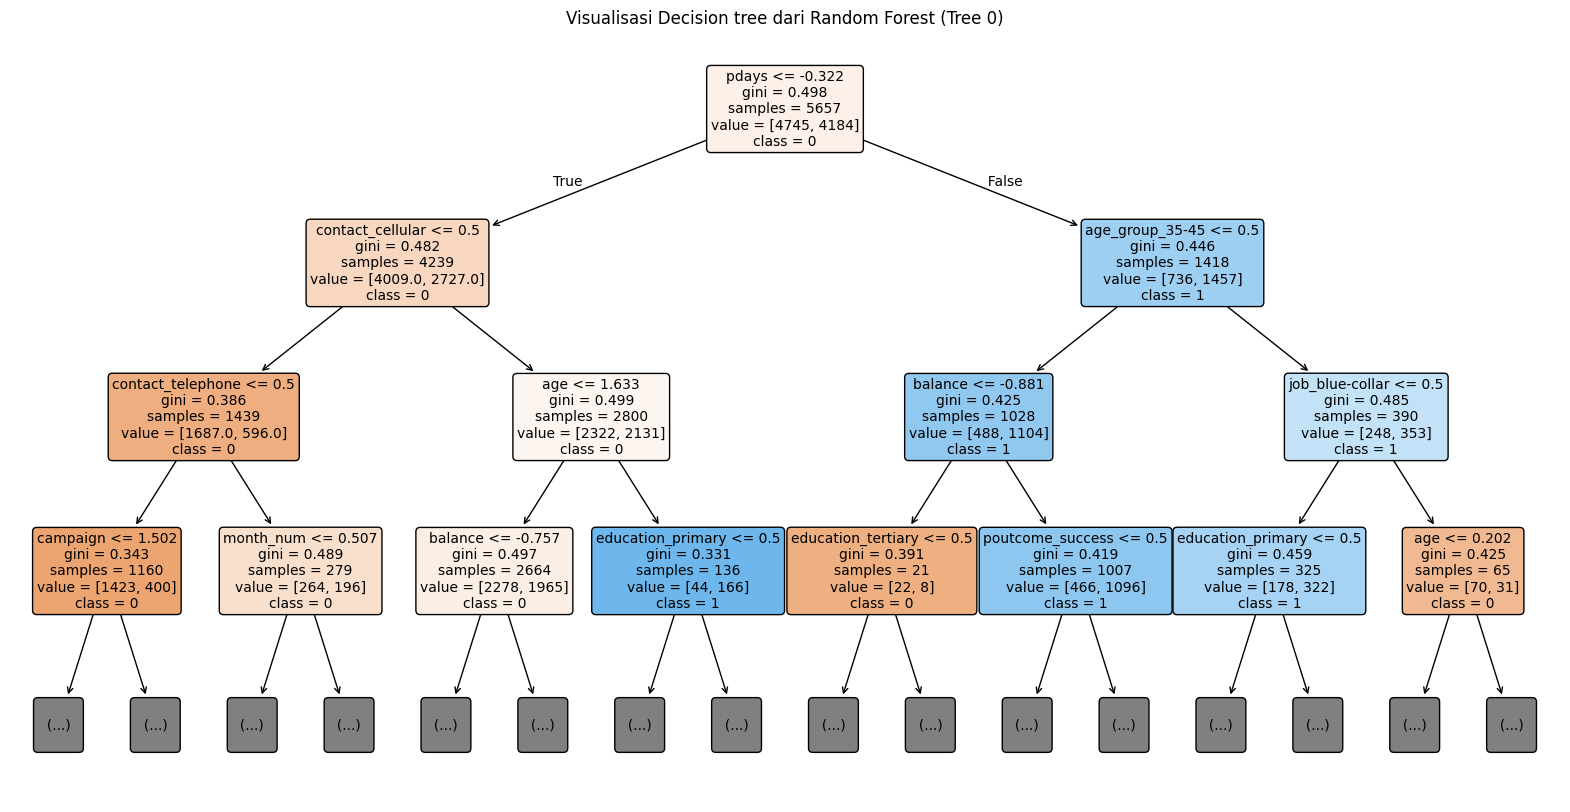

In [ ]:
from sklearn.tree import plot_tree
import graphviz
from sklearn.tree import export_graphviz

# Ambil model random forest dari pipeline (pastikan 'classifier' adalah step-nya)
rf_model = best_pipeline.named_steps['classifier']

plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=feature_names_shap,
          class_names=best_pipeline.named_steps['classifier'].classes_.astype(str),
          filled=True,
          rounded=True,
          max_depth=3, # Batasi kedalaman supaya mudah dibaca
          fontsize=10)
plt.title("Visualisasi Decision tree dari Random Forest (Tree 0)")
plt.show()

In [ ]:
# Pertimbangan Etis dan Mitigasi Bias
print("\n--- Pertimbangan Etis dan Mitigasi Bias ---")
print("Deteksi Bias: Ini adalah area yang kompleks dan memerlukan analisis lebih lanjut.")
print("- Analisis distribusi fitur sensitif (misal: 'age', 'marital', 'job') di antara kelas target.")
print("- Evaluasi metrik kinerja (Accuracy, Recall, Precision) secara terpisah untuk sub-kelompok demografi (misal: pria vs wanita, kelompok usia).")


--- Pertimbangan Etis dan Mitigasi Bias ---
Deteksi Bias: Ini adalah area yang kompleks dan memerlukan analisis lebih lanjut.
- Analisis distribusi fitur sensitif (misal: 'age', 'marital', 'job') di antara kelas target.
- Evaluasi metrik kinerja (Accuracy, Recall, Precision) secara terpisah untuk sub-kelompok demografi (misal: pria vs wanita, kelompok usia).
